# TESS

In [1]:
import numpy as np
import starry
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import matplotlib.pyplot as plt
import theano.tensor as tt

starry.config.lazy = True
starry.config.quiet = True

In [2]:
# importing the data into arrays
# first column of the data file is phase data
TessPhaseHalf = np.loadtxt("GD356allTess.dat", usecols=(0))
TessPhase = np.concatenate((TessPhaseHalf, TessPhaseHalf+1))
# second column of the data file is flux data
TessFluxHalf = np.loadtxt("GD356allTess.dat", usecols=(1))
TessFlux = np.concatenate((TessFluxHalf+1, TessFluxHalf+1))
# third column of the data file is flux error
TessErrorHalf = np.loadtxt("GD356allTess.dat", usecols=(2))
TessError = np.concatenate((TessErrorHalf, TessErrorHalf))

In [3]:
def mean_data(Phase, Flux, Error, bins):

    Phase_split = np.array_split(Phase, bins)
    Flux_split = np.array_split(Flux, bins)
    Error_split = np.array_split(Error, bins)

    meanPhase = [] * bins
    meanFlux = [] * bins
    meanError = [] * bins

    for i in range(bins):

        meanPhase_i = np.mean(Phase_split[i])
        meanFlux_i = np.sum(Flux_split[i] / (Error_split[i]**2))/ np.sum(1/(Error_split[i]**2))

        meanError_i = np.sqrt(1/np.sum(1/(Error_split[i]**2)))

        meanPhase.append(meanPhase_i)
        meanFlux.append(meanFlux_i)
        meanError.append(meanError_i)
        
    return meanPhase, meanFlux, meanError

In [4]:
meanPhase, meanFlux, meanError = mean_data(TessPhase, TessFlux, TessError, 200)

TESS_flux = meanFlux
TESS_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

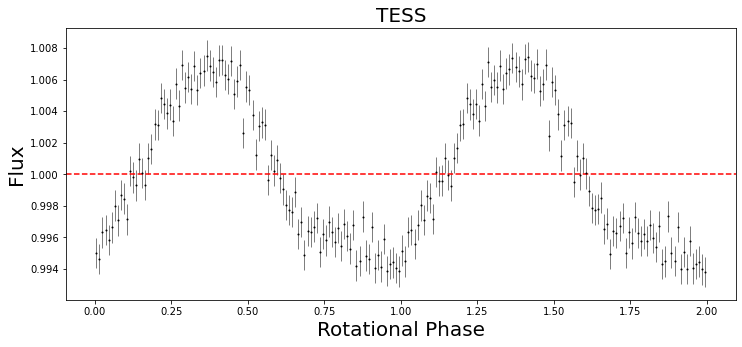

In [5]:
plt.figure(figsize=(12, 5))

plt.title('TESS', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, TESS_flux, yerr=TESS_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [15]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=0.06, testval=0.05)
    radius = 50
    lat = pm.Uniform("lat", lower=0.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=0.1)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=TESS_flux_err, observed=TESS_flux)

In [16]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat, contrast]


message: Optimization terminated successfully.
logp: -925.5952123465119 -> 1023.3537735068023


In [17]:
keys = ["contrast", "lat", "lon", "inc"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.05785
lat          65.36171
lon          45.33448
inc          24.63829


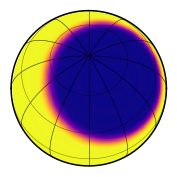

In [18]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.05785, radius=50, lat=65.36171, lon=45.33448)
map.inc = 24.63829
map.show()

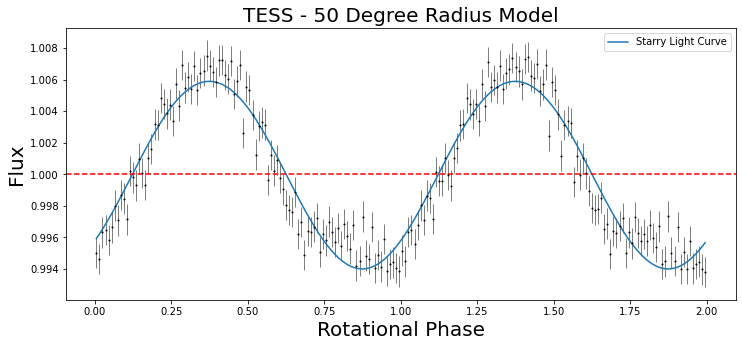

In [19]:
TESS_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('TESS - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, TESS_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, TESS_flux, yerr=TESS_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [20]:
residuals = (TESS_flux - TESS_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.7869652577693063

# LT

In [21]:
# importing the data into arrays
# first column of the data file is phase data
LTPhaseHalf = np.loadtxt("GD356LT.dat", usecols=(0))
LTPhase = np.concatenate((LTPhaseHalf, LTPhaseHalf+1))
# second column of the data file is flux data
LTFluxHalf = np.loadtxt("GD356LT.dat", usecols=(1))
LTFlux = np.concatenate((LTFluxHalf+1, LTFluxHalf+1))
# third column of the data file is flux error
LTErrorHalf = np.loadtxt("GD356LT.dat", usecols=(2))
LTError = np.concatenate((LTErrorHalf, LTErrorHalf))

In [22]:
meanPhase, meanFlux, meanError = mean_data(LTPhase, LTFlux, LTError, 200)

LT_flux = meanFlux
LT_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

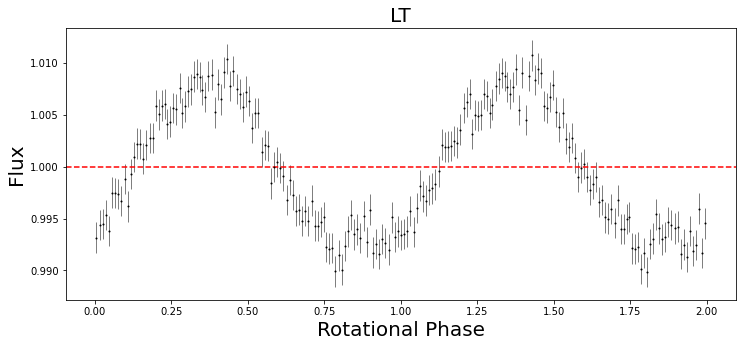

In [24]:
plt.figure(figsize=(12, 5))

plt.title('LT', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, LT_flux, yerr=LT_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [25]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.1)
    radius = 50
    lat = 65.36171
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 24.63829
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=LT_flux_err, observed=LT_flux)

In [26]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Desired error not necessarily achieved due to precision loss.
logp: -486.8465329413595 -> 1012.8088146028817


In [27]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.07792
lon          48.92113


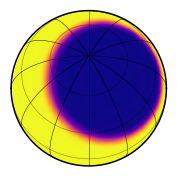

In [28]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.07792, radius=50, lat=65.36171, lon=48.92113)
map.inc = 24.63829
map.show()

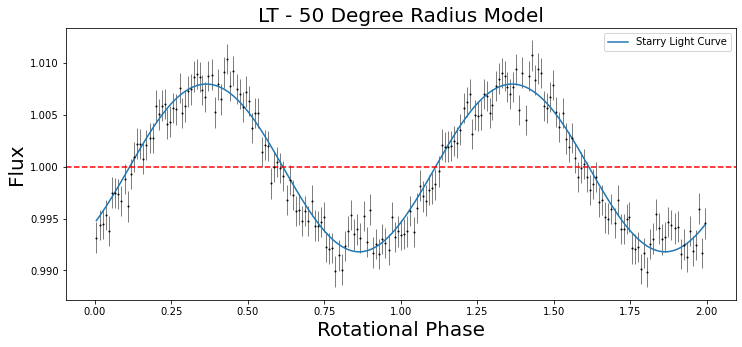

In [29]:
LT_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('LT - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, LT_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, LT_flux, yerr=LT_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [30]:
residuals = (LT_flux - LT_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.0923485971411064

# PTO

In [31]:
# importing the data into arrays
# first column of the data file is phase data
PTO_PhaseHalf = np.loadtxt("GD356PTO.dat", usecols=(0))
PTO_Phase = np.concatenate((PTO_PhaseHalf, PTO_PhaseHalf+1))
# second column of the data file is flux data
PTO_FluxHalf = np.loadtxt("GD356PTO.dat", usecols=(1))
PTO_Flux = np.concatenate((PTO_FluxHalf+1, PTO_FluxHalf+1))
# third column of the data file is flux error
PTO_ErrorHalf = np.loadtxt("GD356PTO.dat", usecols=(2))
PTO_Error = np.concatenate((PTO_ErrorHalf, PTO_ErrorHalf))

In [32]:
meanPhase, meanFlux, meanError = mean_data(PTO_Phase, PTO_Flux, PTO_Error, 200)

PTO_flux = meanFlux
PTO_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

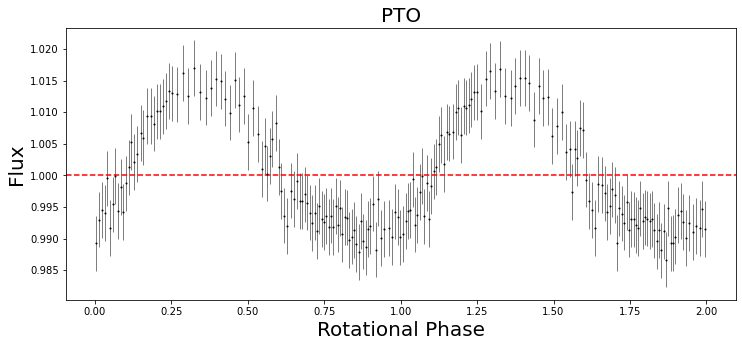

In [33]:
plt.figure(figsize=(12, 5))

plt.title('PTO', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, PTO_flux, yerr=PTO_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [34]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.1)
    radius = 50
    lat = 65.36171
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 24.63829
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=PTO_flux_err, observed=PTO_flux)

In [35]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: 589.2300190201868 -> 858.0452824848924


In [36]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.11352
lon          51.64377


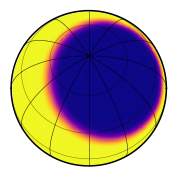

In [37]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.11352, radius=50, lat=65.36171, lon=51.64377)
map.inc = 24.63829
map.show()

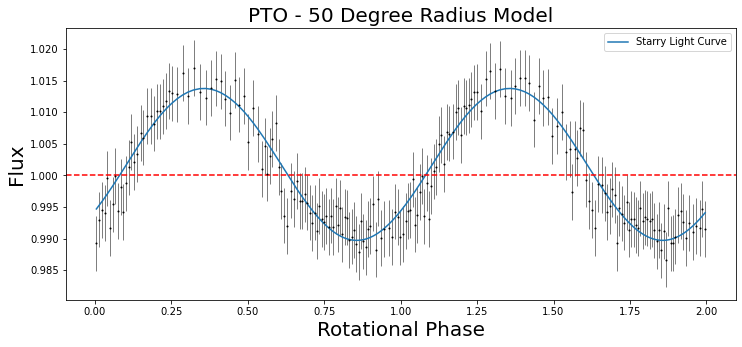

In [38]:
PTO_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('PTO - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, PTO_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, PTO_flux, yerr=PTO_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [39]:
residuals = (PTO_flux - PTO_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

0.4029220341312034

# WHT

In [40]:
# importing the data into arrays
# first column of the data file is phase data
WHT_PhaseHalf = np.loadtxt("GD356WHT.dat", usecols=(0))
WHT_Phase = np.concatenate((WHT_PhaseHalf, WHT_PhaseHalf+1))
# second column of the data file is flux data
WHT_FluxHalf = np.loadtxt("GD356WHT.dat", usecols=(1))
WHT_Flux = np.concatenate((WHT_FluxHalf+1, WHT_FluxHalf+1))
# third column of the data file is flux error
WHT_ErrorHalf = np.loadtxt("GD356WHT.dat", usecols=(2))
WHT_Error = np.concatenate((WHT_ErrorHalf, WHT_ErrorHalf))

In [41]:
meanPhase, meanFlux, meanError = mean_data(WHT_Phase, WHT_Flux, WHT_Error, 200)

WHT_flux = meanFlux
WHT_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

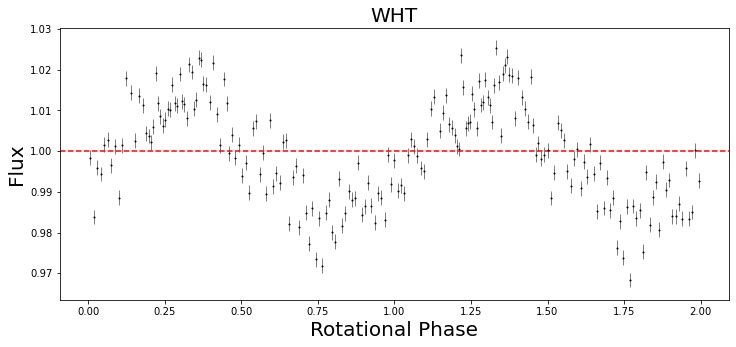

In [42]:
plt.figure(figsize=(12, 5))

plt.title('WHT', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, WHT_flux, yerr=WHT_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [43]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.1)
    radius = 50
    lat = 65.36171
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 24.63829
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=WHT_flux_err, observed=WHT_flux)

In [44]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Desired error not necessarily achieved due to precision loss.
logp: -3311.2802093843343 -> -83.81478849396461


In [45]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.13856
lon          68.43749


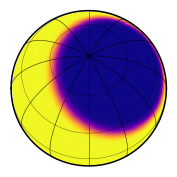

In [46]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.13856, radius=50, lat=65.36171, lon=68.43749)
map.inc = 24.63829
map.show()

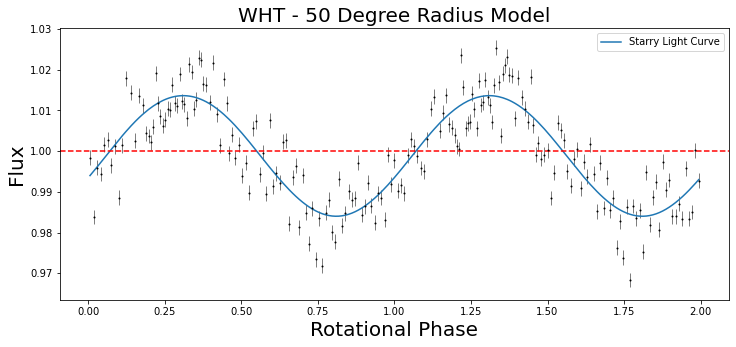

In [47]:
WHT_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('WHT - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, WHT_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, WHT_flux, yerr=WHT_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [48]:
residuals = (WHT_flux - WHT_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

11.849672010097077

# ZTF-r

In [49]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356ZTFR.dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356ZTFR.dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

ZTFr_flux = meanFlux
ZTFr_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

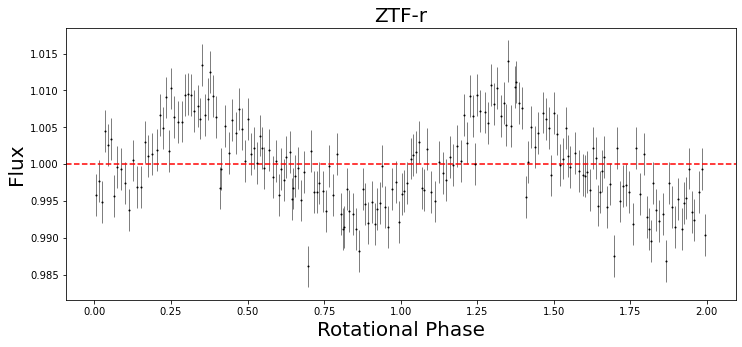

In [50]:
plt.figure(figsize=(12, 5))

plt.title('ZTF-r', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, ZTFr_flux, yerr=ZTFr_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [51]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 50
    lat = 65.36171
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 24.63829
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=ZTFr_flux_err, observed=ZTFr_flux)

In [52]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -222177.6919100082 -> 848.0070030369312


In [53]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.06235
lon          54.91689


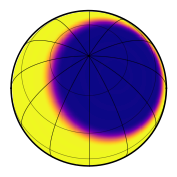

In [54]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.06235, radius=50, lat=65.36171, lon=54.91689)
map.inc = 24.63829
map.show()

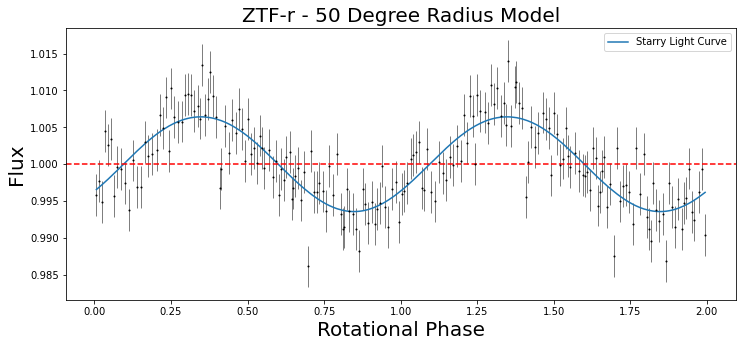

In [55]:
ZTFr_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('ZTF-r - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, ZTFr_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, ZTFr_flux, yerr=ZTFr_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [56]:
residuals = (ZTFr_flux - ZTFr_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.403001831672191

# ZTF-g

In [57]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356ZTFG.dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356ZTFG.dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

ZTFg_flux = meanFlux
ZTFg_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

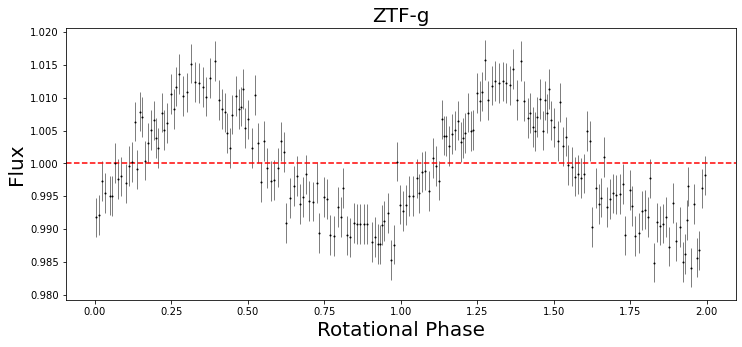

In [58]:
plt.figure(figsize=(12, 5))

plt.title('ZTF-g', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, ZTFg_flux, yerr=ZTFg_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [59]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 50
    lat = 65.36171
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 24.63829
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=ZTFg_flux_err, observed=ZTFg_flux)

In [60]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -198815.874183696 -> 869.7557164509783


In [61]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.10011
lon          53.53798


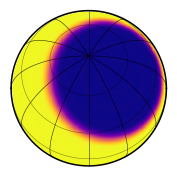

In [62]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.10011, radius=50, lat=65.36171, lon=53.53798)
map.inc = 24.63829
map.show()

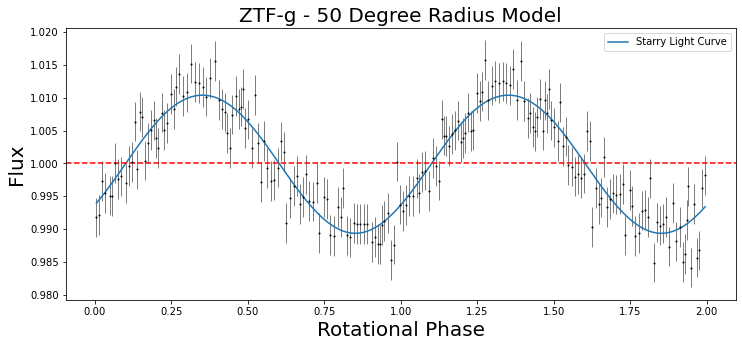

In [63]:
ZTFg_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('ZTF-g - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, ZTFg_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, ZTFg_flux, yerr=ZTFg_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [64]:
residuals = (ZTFg_flux - ZTFg_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.0540231446616015

# NUV

In [65]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTNUV.dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTNUV.dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

NUV_flux = meanFlux
NUV_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

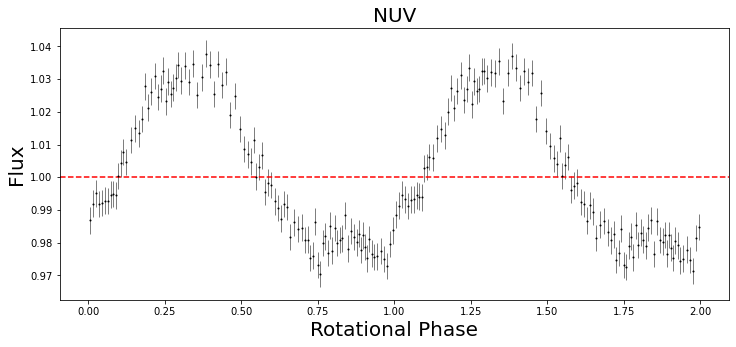

In [66]:
plt.figure(figsize=(12, 5))

plt.title('NUV', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV_flux, yerr=NUV_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [67]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 50
    lat = 65.36171
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 24.63829
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=NUV_flux_err, observed=NUV_flux)

In [68]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -98170.68955565717 -> 743.5411243346134


In [69]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.24478
lon          59.79390


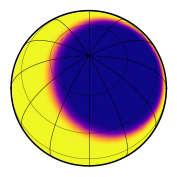

In [70]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.24478, radius=50, lat=65.36171, lon=59.79390)
map.inc = 24.63829
map.show()

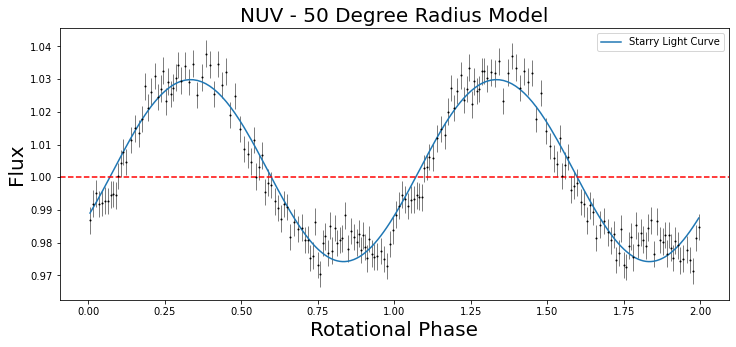

In [71]:
NUV_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('NUV - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, NUV_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV_flux, yerr=NUV_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [72]:
residuals = (NUV_flux - NUV_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.7545027742325805

# NUV (2550 - 2950)

In [73]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTNUV(2550_2950).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTNUV(2550_2950).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

NUV3_flux = meanFlux
NUV3_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

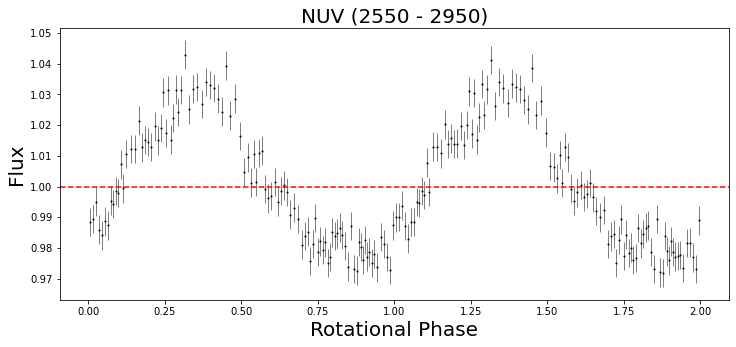

In [74]:
plt.figure(figsize=(12, 5))

plt.title('NUV (2550 - 2950)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV3_flux, yerr=NUV3_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [75]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 50
    lat = 65.36171
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 24.63829
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=NUV3_flux_err, observed=NUV3_flux)

In [76]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -73414.77592781714 -> 734.9745487370964


In [78]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.23246
lon          52.89866


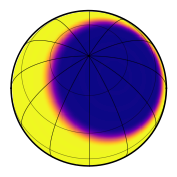

In [79]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.23246, radius=50, lat=65.36171, lon=52.89866)
map.inc = 24.63829
map.show()

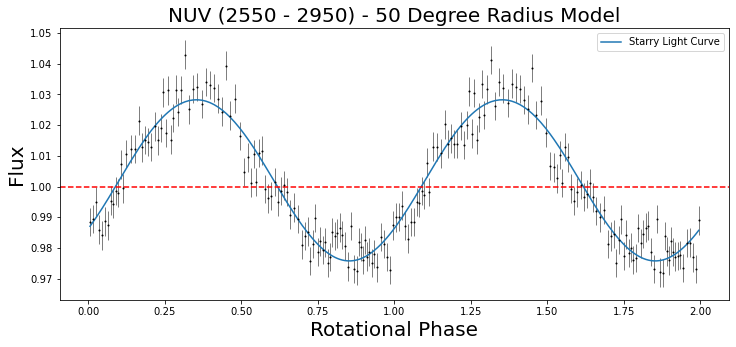

In [80]:
NUV3_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('NUV (2550 - 2950) - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, NUV3_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV3_flux, yerr=NUV3_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [81]:
residuals = (NUV3_flux - NUV3_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.5710223340674847

# NUV (2150 - 2550)

In [82]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTNUV(2150_2550).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTNUV(2150_2550).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

NUV2_flux = meanFlux
NUV2_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

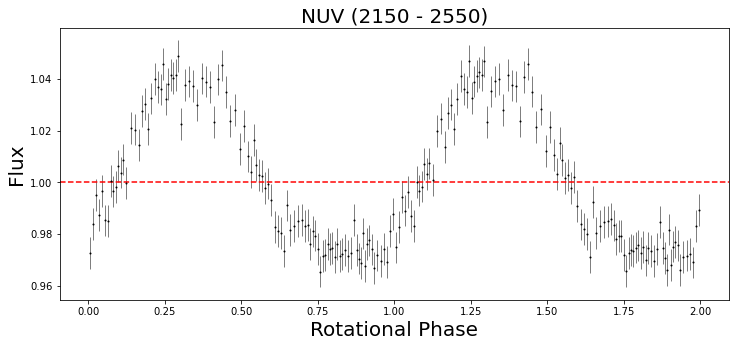

In [83]:
plt.figure(figsize=(12, 5))

plt.title('NUV (2150 - 2550)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV2_flux, yerr=NUV2_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [84]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 50
    lat = 65.36171
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 24.63829
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=NUV2_flux_err, observed=NUV2_flux)

In [85]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -41578.85432894878 -> 695.074023655564


In [86]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.29767
lon          60.85589


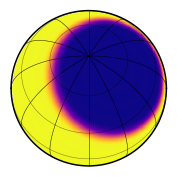

In [87]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.29767, radius=50, lat=65.36171, lon=60.85589)
map.inc = 24.63829
map.show()

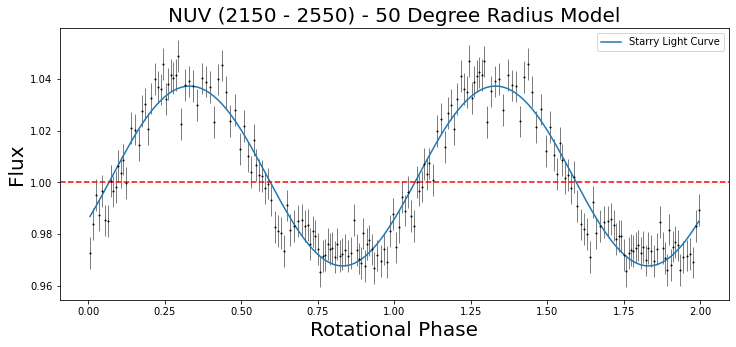

In [88]:
NUV2_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('NUV (2150 - 2550) - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, NUV2_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV2_flux, yerr=NUV2_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [89]:
residuals = (NUV2_flux - NUV2_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.4021051771691464

# NUV (1630 - 2150)

In [90]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTNUV(1630_2150).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTNUV(1630_2150).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

NUV1_flux = meanFlux
NUV1_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

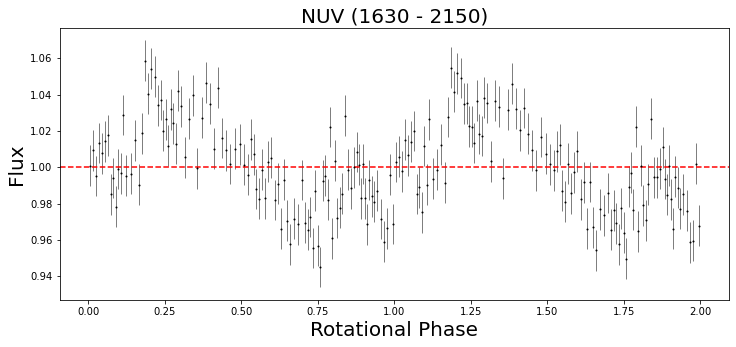

In [91]:
plt.figure(figsize=(12, 5))

plt.title('NUV (1630 - 2150)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV1_flux, yerr=NUV1_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [92]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 50
    lat = 65.36171
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 24.63829
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=NUV1_flux_err, observed=NUV1_flux)

In [93]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -13678.86180881841 -> 483.7956006090886


In [94]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.21949
lon          78.01050


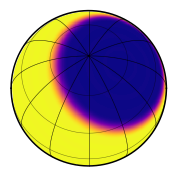

In [95]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.21949, radius=50, lat=65.36171, lon=78.01050)
map.inc = 24.63829
map.show()

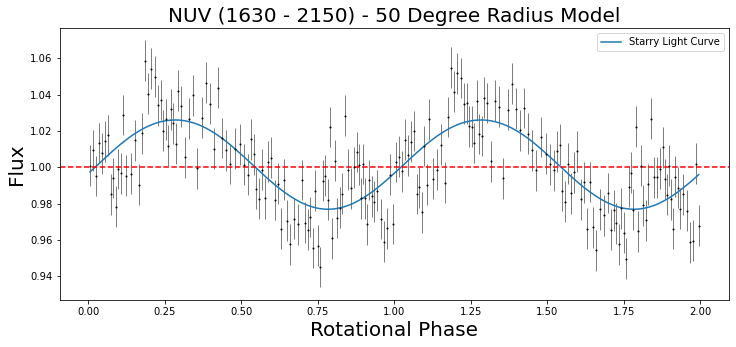

In [96]:
NUV1_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('NUV (1630 - 2150) - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, NUV1_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV1_flux, yerr=NUV1_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [97]:
residuals = (NUV1_flux - NUV1_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

2.3258146176026835

# FUV

In [98]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTFUV.dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTFUV.dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

FUV_flux = meanFlux
FUV_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

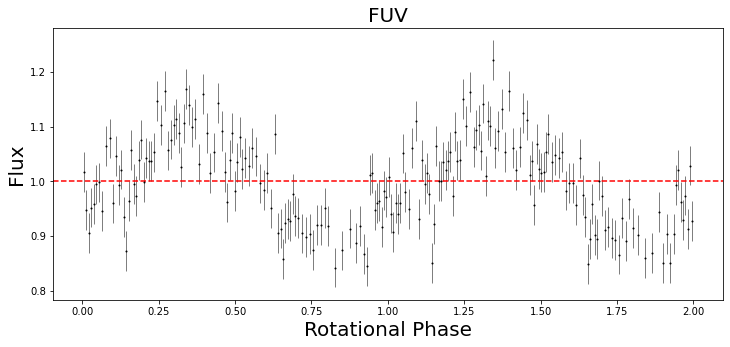

In [99]:
plt.figure(figsize=(12, 5))

plt.title('FUV', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV_flux, yerr=FUV_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [100]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 50
    lat = 65.36171
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 24.63829
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV_flux_err, observed=FUV_flux)

In [101]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -817.9243556036722 -> 292.9817923199365


In [102]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.64555
lon          58.17759


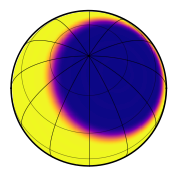

In [103]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.64555, radius=50, lat=65.36171, lon=58.17759)
map.inc = 24.63829
map.show()

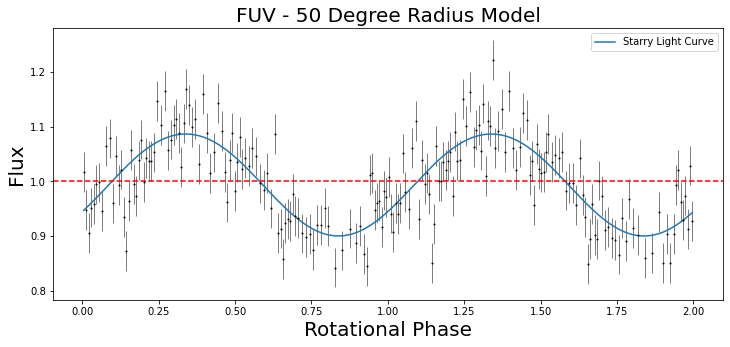

In [104]:
FUV_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('FUV - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, FUV_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV_flux, yerr=FUV_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [105]:
residuals = (FUV_flux - FUV_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.8788371135899589

# FUV (1520 - 1715)

In [106]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTFUV(1520_1715).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTFUV(1520_1715).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

FUV3_flux = meanFlux
FUV3_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

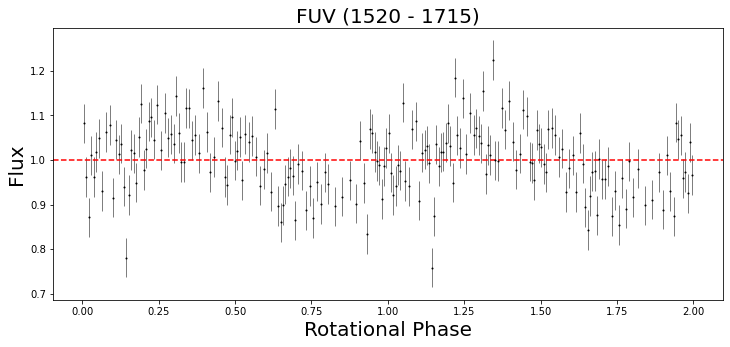

In [107]:
plt.figure(figsize=(12, 5))

plt.title('FUV (1520 - 1715)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV3_flux, yerr=FUV3_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [108]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 50
    lat = 65.36171
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 24.63829
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV3_flux_err, observed=FUV3_flux)

In [109]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -644.563845323731 -> 228.69296627208948


In [110]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.46911
lon          66.07615


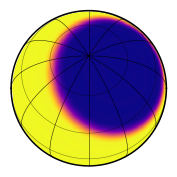

In [111]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.46911, radius=50, lat=65.36171, lon=66.07615)
map.inc = 24.63829
map.show()

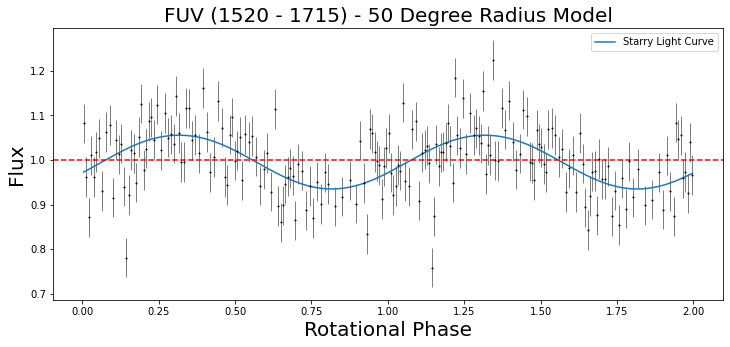

In [112]:
FUV3_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('FUV (1520 - 1715) - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, FUV3_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV3_flux, yerr=FUV3_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [113]:
residuals = (FUV3_flux - FUV3_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

2.140890170306445

# FUV (1330 - 1520)

In [114]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTFUV(1330_1520).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTFUV(1330_1520).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

FUV2_flux = meanFlux
FUV2_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

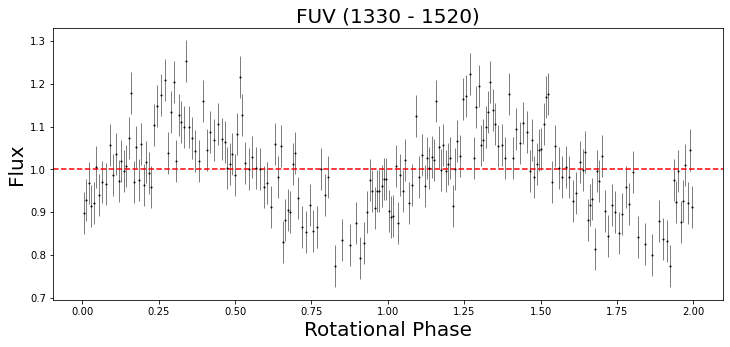

In [115]:
plt.figure(figsize=(12, 5))

plt.title('FUV (1330 - 1520)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV2_flux, yerr=FUV2_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [116]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 50
    lat = 65.36171
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 24.63829
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV2_flux_err, observed=FUV2_flux)

In [117]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -327.8943356937977 -> 258.622291840679


In [118]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.72231
lon          56.19106


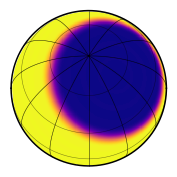

In [119]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.72231, radius=50, lat=65.36171, lon=56.19106)
map.inc = 24.63829
map.show()

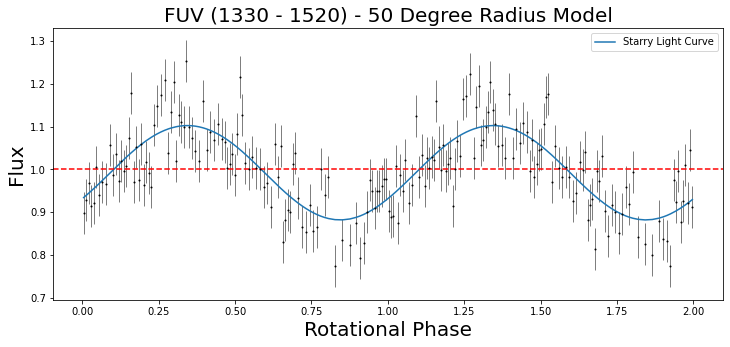

In [120]:
FUV2_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('FUV (1330 - 1520) - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, FUV2_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV2_flux, yerr=FUV2_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [121]:
residuals = (FUV2_flux - FUV2_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.6198720313917445

# FUV (1120 - 1330)

In [122]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTFUV(1120_1330).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTFUV(1120_1330).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

FUV1_flux = meanFlux
FUV1_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

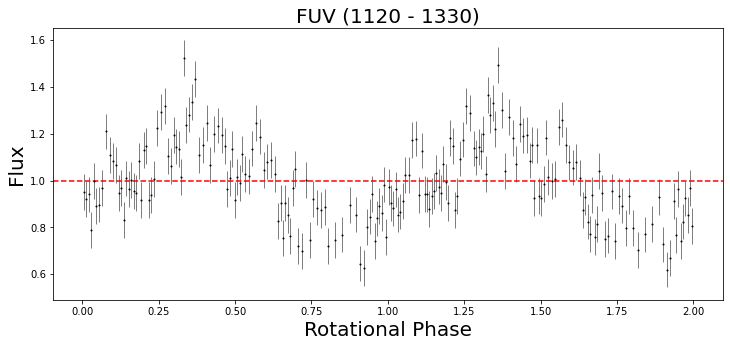

In [123]:
plt.figure(figsize=(12, 5))

plt.title('FUV (1120 - 1330)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV1_flux, yerr=FUV1_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [124]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 50
    lat = 65.36171
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 24.63829
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV1_flux_err, observed=FUV1_flux)

In [125]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -137.5415011572316 -> 110.018512499589


In [126]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.98053
lon          50.64799


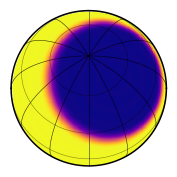

In [127]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.98053, radius=50, lat=65.36171, lon=50.64799)
map.inc = 24.63829
map.show()

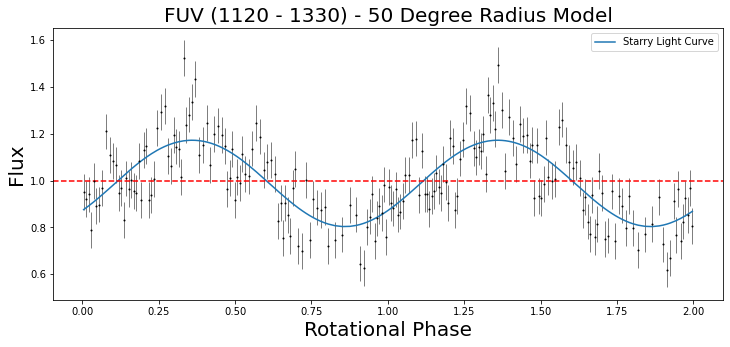

In [128]:
FUV1_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('FUV (1120 - 1330) - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, FUV1_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV1_flux, yerr=FUV1_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [129]:
residuals = (FUV1_flux - FUV1_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

2.216524214485711